# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
#загрузка библиотек
!pip install catboost

In [ ]:
#импорт библиотек

import os

from time import time

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np

from matplotlib import pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

In [ ]:
#загрузка данных

pth1 = 'autos.csv'
pth2 = 'C:\projects\numerical_methods\autos.csv'

if os.path.exists(pth1):
    autos = pd.read_csv(pth1, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2):
    autos = pd.read_csv(pth2, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong')

In [ ]:
#вывод основной информации о датафрейме
dfdict = {
    'autos': autos
}

def dfinf(df):
    print(f'Название датафрейма: {df}\n')
    dfdict[df].info()
    display(dfdict[df].head())

_ = list(map(dfinf, dfdict))

Название датафрейма: autos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [ ]:
#проведем стартовую предобработку
def start_preproc(df):
    print(f'Название датафрейма: {df}\n')
    dfdict[df] = dfdict[df].drop_duplicates()
    display(dfdict[df].isnull().sum())
    display(dfdict[df].describe(include='all'))

_ = list(map(start_preproc, dfdict))

Название датафрейма: autos



DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,354365.000000,321470,354365,283211,354365,354365.0,354365.000000,354365
unique,NaN,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,NaN,NaN,NaN,NaN
top,NaN,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,NaN,NaN,NaN,NaN
freq,NaN,NaN,91457,NaN,268249,NaN,29232,NaN,NaN,216349,77012,247158,NaN,NaN,NaN,NaN
mean,2016-03-21 12:58:09.520460544,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,5.714650,NaN,NaN,NaN,2016-03-20 19:12:06.583042560,0.0,50508.503800,2016-03-29 23:51:06.766184960
min,2016-03-05 14:06:22,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:52
75%,2016-03-29 14:37:20,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,NaN,9999.000000,NaN,20000.000000,NaN,150000.000000,12.000000,NaN,NaN,NaN,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51


In [ ]:
#столбец NumberOfPictures абсолютно пустой - удалим его
autos = autos.drop('NumberOfPictures', axis=1)

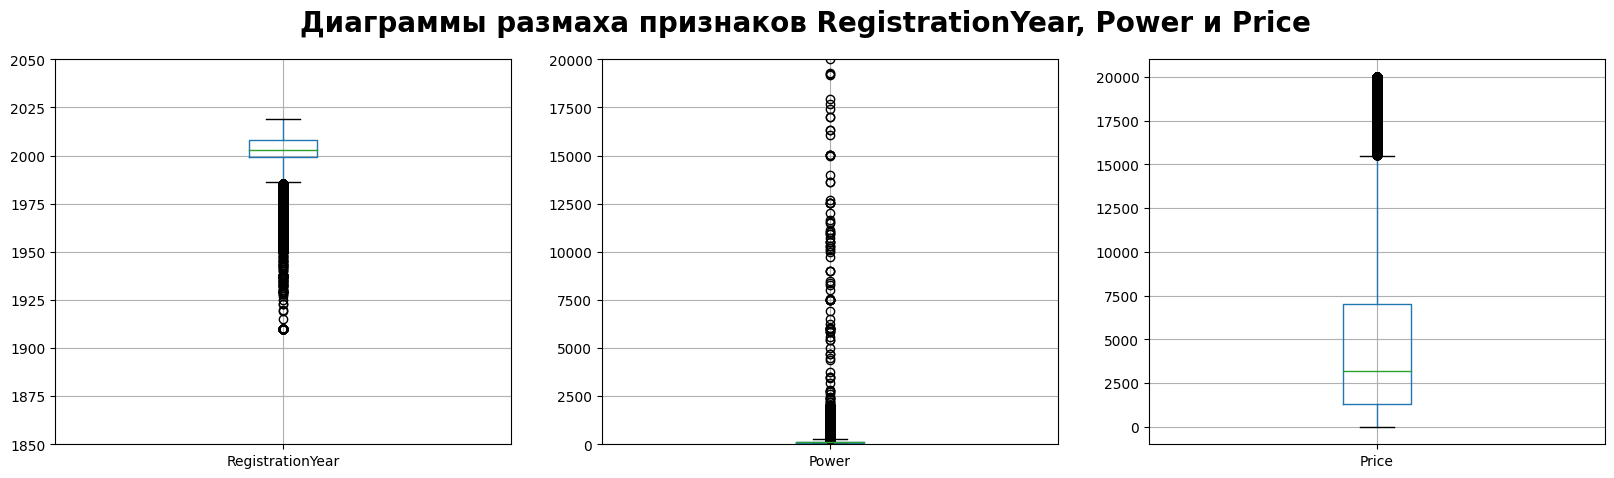

In [ ]:
#рассмотрим диаграммы для годов регистрации автомобилей, мощностей и цены
fig, axes = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Диаграммы размаха признаков RegistrationYear, Power и Price', fontsize=20, fontweight='bold')
autos.boxplot(column='RegistrationYear', ax=axes[0]);
axes[0].set_ylim([1850,2050]);
autos = autos.query('RegistrationYear > 1900 and RegistrationYear <= 2016')
autos.boxplot(column='Power', ax=axes[1]);
axes[1].set_ylim([0,20000]);
autos = autos.query('Power > 50 and Power < 2000')
autos.boxplot(column='Price', ax=axes[2]);
autos = autos.query('Price > 0')

In [ ]:
#в таблице имеются строки с нулевым месяцем регистрации - удалим их
autos = autos.query('RegistrationMonth != 0')

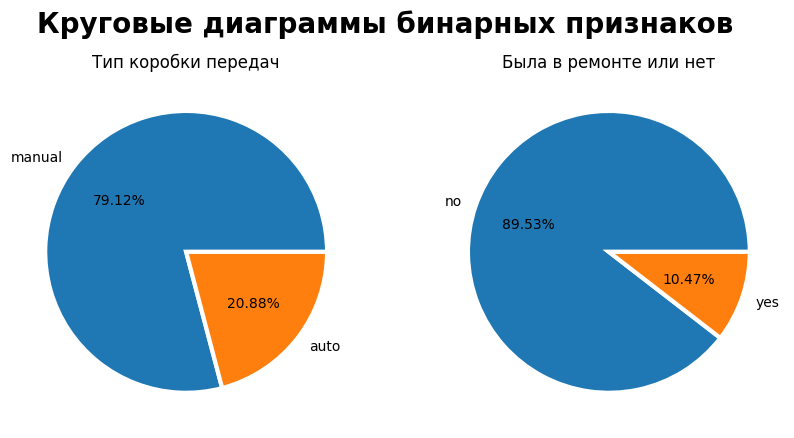

In [ ]:
#взглянем на бинарные признаки
def pieplt (df, col, name, axes):
    df.value_counts(col).plot.pie(title=name, ylabel='', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},\
                       legend=False, autopct='%0.2f%%', fontsize=10, ax=axes);

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Круговые диаграммы бинарных признаков', fontsize=20, fontweight='bold')
pieplt(autos, 'Gearbox', 'Тип коробки передач', axes[0])
pieplt(autos, 'Repaired', 'Была в ремонте или нет', axes[1])

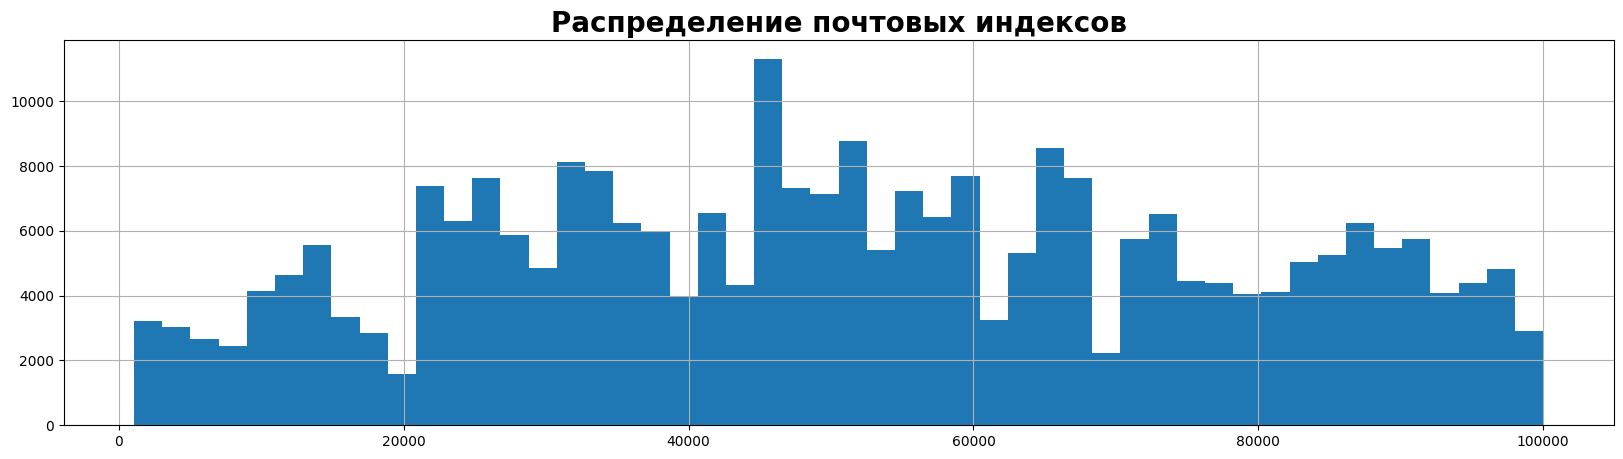

In [ ]:
#распределение почтовых индексов
autos.hist(column='PostalCode', bins=50, figsize=(20,5));
plt.title('Распределение почтовых индексов', fontsize=20, fontweight='bold');

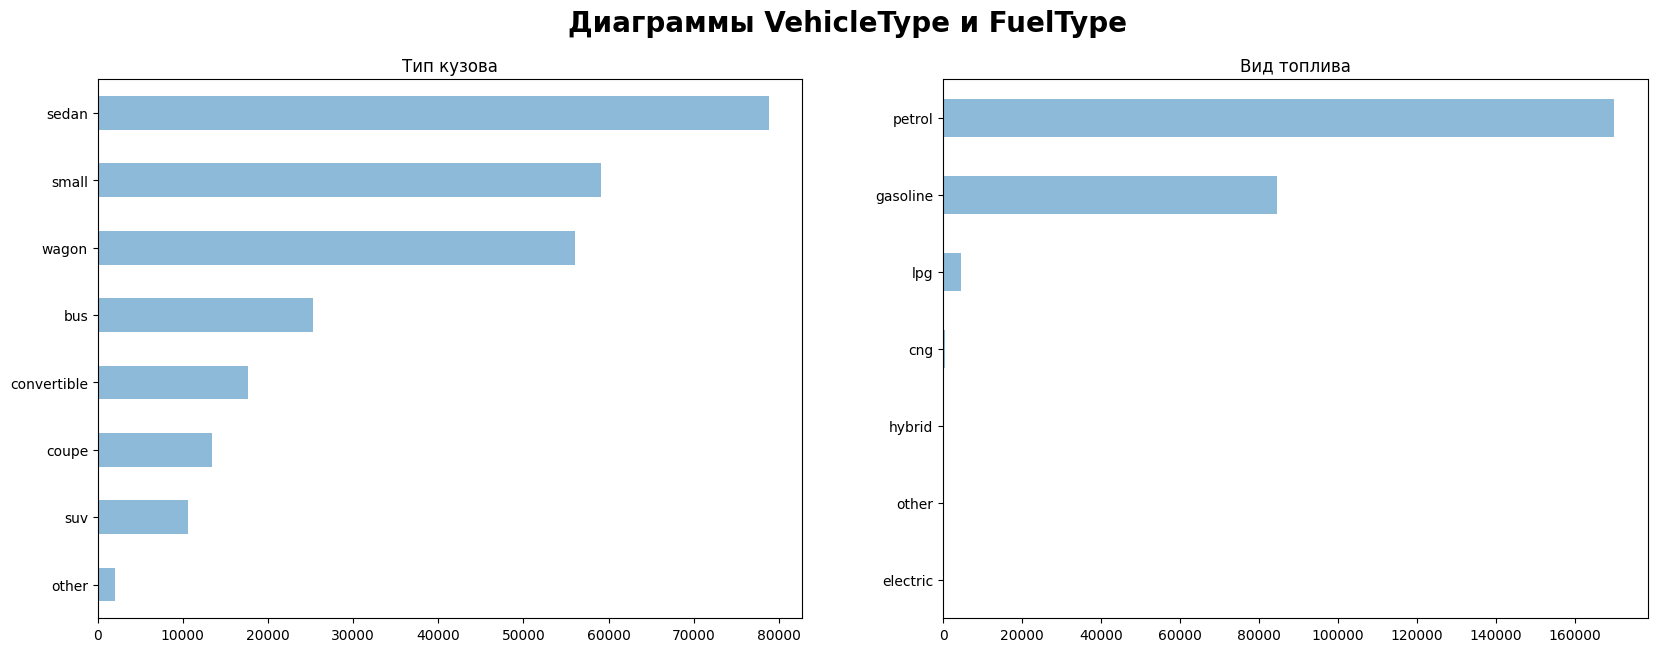

In [ ]:
#Горизонтальные диаграммы VehicleType и FuelType
def barhplt (df, col, name, axes):
    df.value_counts(col, ascending=True).plot.barh(title=name, ylabel='', xlabel='',\
                       legend=False, alpha=0.5, fontsize=10, ax=axes);

fig, axes = plt.subplots(1, 2, figsize=(20,7))
fig.suptitle('Диаграммы VehicleType и FuelType', fontsize=20, fontweight='bold')
barhplt(autos, 'VehicleType', 'Тип кузова', axes[0])
barhplt(autos, 'FuelType', 'Вид топлива', axes[1])

autos['FuelType'] = autos['FuelType'].replace('gasoline', 'petrol')

In [ ]:
#проверим неявные дубликаты в столбцах Model и Brand
display(autos['Brand'].unique())
display(autos['Model'].unique())

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'honda', 'fiat',
       'mini', 'smart', 'hyundai', 'sonstige_autos', 'opel', 'subaru',
       'volvo', 'mitsubishi', 'alfa_romeo', 'kia', 'seat', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'suzuki', 'daihatsu',
       'chrysler', 'jaguar', 'rover', 'porsche', 'saab', 'daewoo',
       'land_rover', 'lada', 'trabant'], dtype=object)

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'other', 'civic', 'punto', 'e_klasse', 'clio', 'one',
       'fortwo', '1er', 'b_klasse', 'a8', 'jetta', 'c_klasse', 'micra',
       'vito', 'sprinter', 'astra', 'escort', 'forester', 'xc_reihe',
       'fiesta', 'scenic', 'a1', 'transporter', 'focus', 'a4', 'tt', 'a6',
       'jazz', 'omega', 'polo', 'slk', '7er', 'combo', '80', '147',
       'z_reihe', 'sorento', 'ibiza', 'mustang', 'eos', 'touran', 'getz',
       'insignia', 'ka', 'almera', 'megane', 'a3', 'r19', 'mondeo',
       'cordoba', 'colt', 'corsa', 'vectra', 'lupo', 'berlingo', 'tiguan',
       '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed', 'kangoo',
       '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'caddy',
       'spider', 'cuore', 's_max', 'modus', 'a2', 'galaxy', 'c3', 'viano',
       '

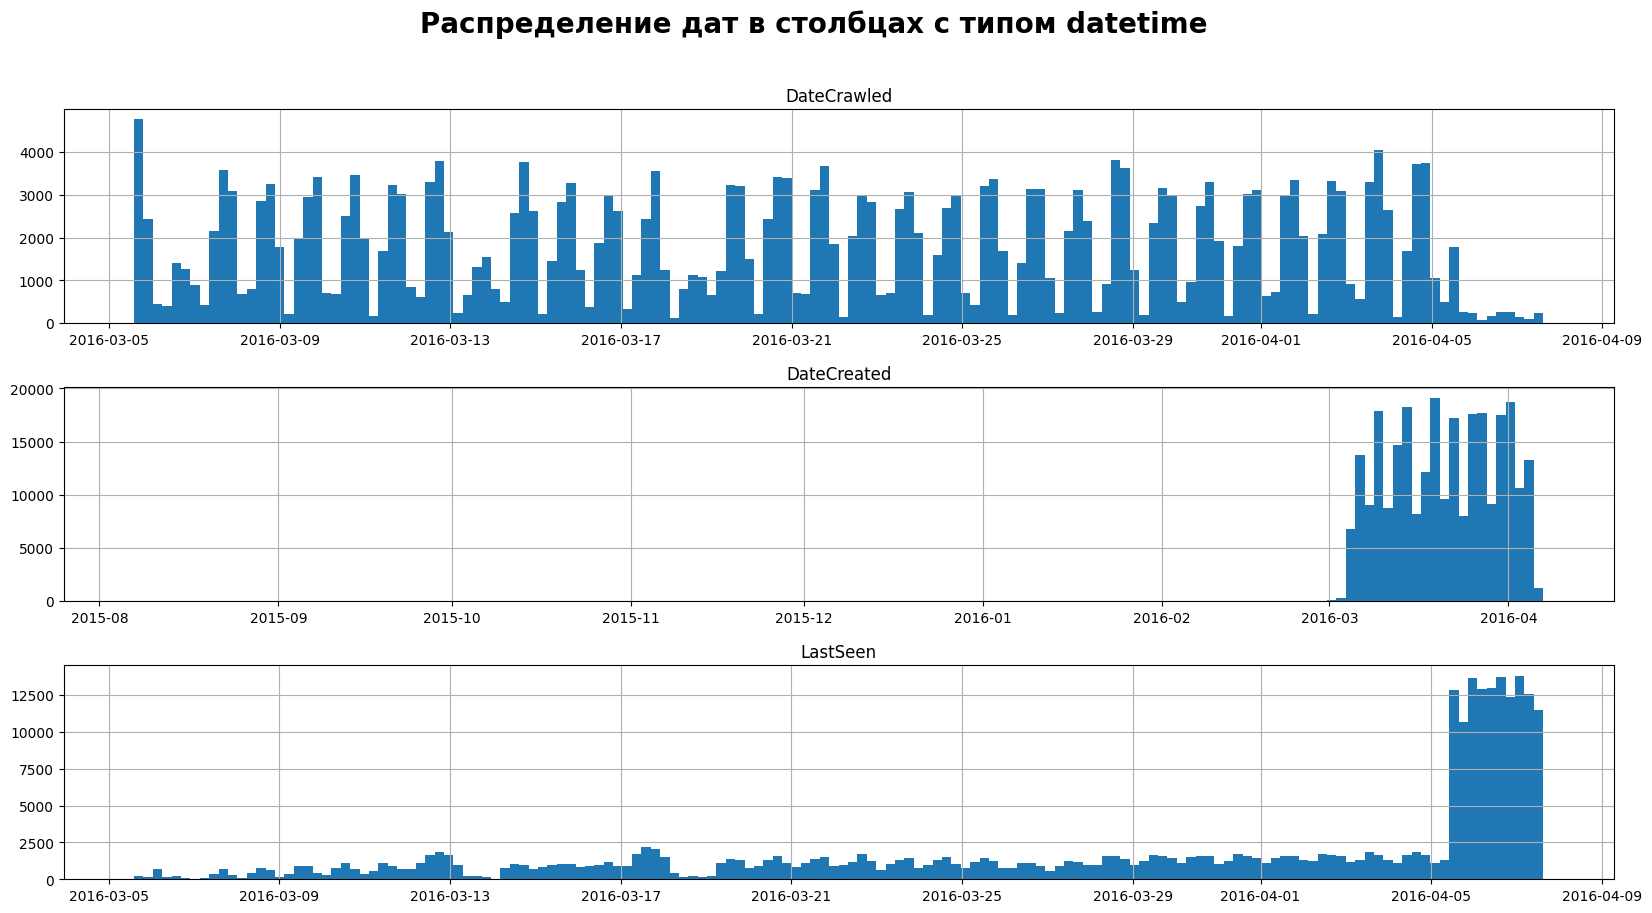

In [ ]:
#рассмотрим гистограммы для столбцов типа datetime
fig, axes = plt.subplots(3, 1, figsize=(20,10))
fig.suptitle('Распределение дат в столбцах с типом datetime', fontsize=20, fontweight='bold')
autos.hist(column='DateCrawled', bins=150, ax=axes[0]);
autos.hist(column='DateCreated', bins=150, ax=axes[1]);
autos.hist(column='LastSeen', bins=150, ax=axes[2]);
autos = autos[autos['DateCreated'].dt.to_period('M') >= '2016-03']

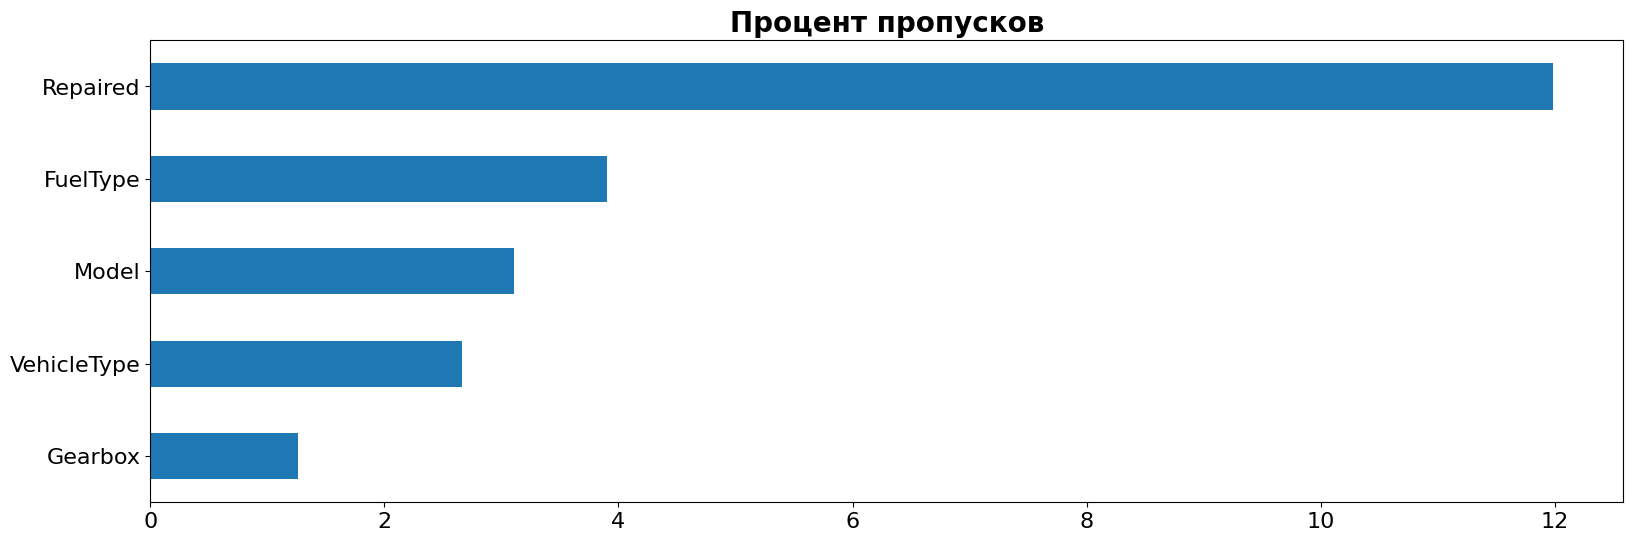

In [ ]:
#визуализируем оставшиеся пропуски после удаления аномальных значений
def pass_value_barh(df):
    (df.isna().mean()*100)\
    .to_frame()\
    .rename(columns = {0:'space'})\
    .query('space > 0')\
    .sort_values(by = 'space', ascending = True)\
    .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)\
    .set_title('Процент пропусков', fontsize=20, fontweight='bold')

pass_value_barh(autos)


In [ ]:
#заполним оставшиеся строки с помощью Simple Imputer и проверим пропуски
imputer = SimpleImputer(
    strategy='constant',
    fill_value='tbd'
)

null_columns = ['Repaired', 'VehicleType', 'FuelType', 'Model', 'Gearbox']

autos[null_columns] = imputer.fit_transform(autos[null_columns])

dfdict = {
    'autos': autos
}

_ = list(map(start_preproc, dfdict))

Название датафрейма: autos



DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
count,269689,269689.00000,269689,269689.000000,269689,269689.000000,269689,269689.000000,269689.000000,269689,269689,269689,269689,269689.000000,269689
unique,NaN,NaN,9,NaN,3,NaN,249,NaN,NaN,7,40,3,NaN,NaN,NaN
top,NaN,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,NaN,NaN,NaN
freq,NaN,NaN,78718,NaN,210699,NaN,22875,NaN,NaN,254033,56051,212498,NaN,NaN,NaN
mean,2016-03-21 13:32:50.986803456,5115.10508,NaN,2003.187427,NaN,124.568099,NaN,127977.652036,6.384554,NaN,NaN,NaN,2016-03-20 20:41:35.087304704,51521.278958,2016-03-30 06:24:43.079621632
min,2016-03-05 14:06:22,1.00000,NaN,1910.000000,NaN,51.000000,NaN,5000.000000,1.000000,NaN,NaN,NaN,2016-03-01 00:00:00,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:48:49,1500.00000,NaN,1999.000000,NaN,84.000000,NaN,125000.000000,4.000000,NaN,NaN,NaN,2016-03-13 00:00:00,31162.000000,2016-03-23 15:48:27
50%,2016-03-21 18:37:19,3500.00000,NaN,2003.000000,NaN,116.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,2016-03-21 00:00:00,50767.000000,2016-04-04 06:48:31
75%,2016-03-29 14:53:59,7490.00000,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,2016-03-29 00:00:00,72290.000000,2016-04-06 11:15:57
max,2016-04-07 14:36:58,20000.00000,NaN,2016.000000,NaN,1998.000000,NaN,150000.000000,12.000000,NaN,NaN,NaN,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:51


**Загрузка и предобработка данных**<br>
*Датасет `autos.csv`* содержит следующие данные:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — **целевой признак**, цена (евро)

При стартовой предобработке данных были обнаружены пустые значения и аномалии в данных. Сразу же удаляем из таблицы колонку `NumberOfPictures`, так как она абсолютно пустая. Далее рассмотрим столбцы `RegistrationYear, Power и Price`. Достаточно странно видеть год регистрации до 1900 года или после 2020-х. С помощью диаграммы размаха определяем основной диапазон для годов (конечно, автомобили 1910-х и 1920-х годов тоже достаочно редки, но такие хотя бы теоретически могут встречаться, в отличие от 1800 или вообще 1000 года). Также обращает внимание тот факт, что **объявления датируются не позднее 2016 года** - соответственно, год регистрации автомобиля не может превышать *2016*.<br>
Похожая ситуация и с `Power` - автомобили мощностью *свыше 2000 л.с.* хоть и существуют, но точно не являются массовой категорией, поэтому такие значения можно отсечь, так как, скорее всего, это опечатка, а не реальное значение. Аналогично и с минимальным значением - автомобили *меньше 50 л.с.* также можно не учитывать. *Нулевая стоимость* (`Price`) автомобиля выглядит не очень реалистично, поэтому "бесплатные" автомобили из выборки удалим.<br>
Типов кузова (`VehicleType`) насчитывается *8* видов, самый популярный - *седан*. На *40* автомобильных брендов (`Brand`) в предобработанной таблице *248* моделей машин. `FuelType` изначально было 7, однако *petrol* и *gasoline* по сути являются одним и тем те бензином, поэтому были объединены в одну категорию.<br>
При просмотре дат выгрузки, размещения и последней проверки объявлений (`DateCrawled, DateCreated и LastSeen`) был замечен малый процент объявлений с датами создания до `марта 2016 года`. Раз эти объявления до сих пор висят на сайте, значит, машины из этих объявлений продаются гораздо дольше основной массы авто - возможно, у них не самая адекватная цена или хозяин авто не отвечает на сообщения. Подобные объявления также уберем из выборки. Оценим распределение `PostalCode` - почтовые индексы распределены относительно равномерно, хоть и с заметными пиками, но это соотносится с тем, как эти индексы назначаются.<br>
*Около 80% автомобилей* на ручной коробке передач (`Gearbox`) и *почти 90%* не были в ремонте - по крайней мере, такие выводы можно сделать по заполненным ячейкам. В колонке `Repaired` даже после удаления аномальных значений осталось более 12% пропусков. Пустые значения заполнены с помощью *SimpleImputer* заглушкой **tbd**.

## Обучение моделей

In [ ]:
#выделим модель для обучения без лишних признаков
autos_train = autos.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode'])
autos_train = autos_train.drop_duplicates()

In [ ]:
#подготовим выборки
RANDOM_STATE = 12345

features_train, features_test, target_train, target_test = train_test_split(
    autos_train.drop(columns='Price'),\
    autos_train.Price,\
    test_size=0.25,\
    random_state=RANDOM_STATE)

In [ ]:
#кодируем данные
cols_ord = features_train.select_dtypes(include='object').columns.tolist()
ord_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)
features_train[cols_ord] = ord_encoder.fit_transform(features_train[cols_ord])
features_test[cols_ord] = ord_encoder.transform(features_test[cols_ord])

cols_num = features_train.select_dtypes(exclude='object').columns.tolist()
scaler = StandardScaler()
features_train[cols_num] = ord_encoder.fit_transform(features_train[cols_num])
features_test[cols_num] = ord_encoder.transform(features_test[cols_num])

In [ ]:
#подготовим вспомогательные функции
def rscv (model, parameters):
    rs = RandomizedSearchCV(
        model,
        parameters,
        n_jobs=-1,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE
    )

    rs.fit(features_train, target_train)

    rmse = -rs.best_score_

    model = rs.best_estimator_
    return rmse, model

def timers(model):
    start = time()
    model.fit(features_train, target_train)
    end = time()
    model_time_train = (end-start)

    start = time()
    model.predict(features_train)
    end = time()
    model_time_pred = (end-start)
    return model_time_train, model_time_pred

In [ ]:
#инициализируем модель CatBoostRegressor и подберем гиперпараметры с помощью RandomizedSearchCV
model_cat = CatBoostRegressor(learning_rate=1, verbose=False, random_state=RANDOM_STATE)

parameters_cat = {
    'min_data_in_leaf': range(2, 10),
    'max_depth': range(2, 10)
}

rmse_cat, model_cat = rscv(model_cat, parameters_cat)

In [ ]:
#замеряем время обучения и предсказания модели CatBoostRegressor
model_time_train_cat, model_time_pred_cat = timers(model_cat)

In [ ]:
#инициализируем модель LGBMRegressor и подберем гиперпараметры с помощью RandomizedSearchCV
model_lgb = LGBMRegressor(learning_rate=1, random_state=RANDOM_STATE)

parameters_lgb = {
    'num_leaves': range(25, 35),
    'max_depth': range(2, 10)
}

rmse_lgb, model_lgb = rscv(model_lgb, parameters_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 175122, number of used features: 9
[LightGBM] [Info] Start training from score 5208.960565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
#замеряем время обучения и предсказания модели CatBoostRegressor
model_time_train_lgb, model_time_pred_lgb = timers(model_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 175122, number of used features: 9
[LightGBM] [Info] Start training from score 5208.960565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
#инициализируем модель DecisionTreeRegressor и подберем гиперпараметры с помощью RandomizedSearchCV
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters_dtr = {
    'min_samples_leaf': range(2, 40),
    'max_depth': range(2, 100)
}

rmse_dtr, model_dtr = rscv(model_dtr, parameters_dtr)

In [ ]:
#замеряем время обучения и предсказания модели DecisionTreeRegressor
model_time_train_dtr, model_time_pred_dtr = timers(model_dtr)

In [ ]:
#инициализируем модель DummyRegressor для сравнения
model_dummy = DummyRegressor(strategy='constant', constant=target_train.mean())

model_dummy.fit(features_train, target_train)
pred_train_dummy = model_dummy.predict(features_train)
pred_test_dummy = model_dummy.predict(features_test)

rmse_dummy_train = mean_squared_error(target_train, pred_train_dummy , squared=False)
rmse_dummy_test = mean_squared_error(target_test, pred_test_dummy, squared=False)
print('RMSE для DummyRegressor на тренировочной выборке:', rmse_dummy_train)
print('RMSE для DummyRegressor на тестовой выборке:', rmse_dummy_test)

RMSE для DummyRegressor на тренировочной выборке: 4720.104729191507
RMSE для DummyRegressor на тестовой выборке: 4718.393566601474


**Обучение моделей**<br>
При подготовке выборок для обучения моделей предсказания рыночной стоимости автомобиля были убраны признаки, не влияющие на стоимость. К таким относятся *даты скачивания анкеты, создания анкеты и последней активности пользователя, почтовый код*. *Почтовый код* тоже не влияет на стоимость. *Месяц регистрации автомобиля* малоинформативен в отличие от года регистрации, поэтому для уменьшения количества признаков и, соответсвенно, времени обработки выборок эта колонка была удалена.<br>
В качестве моделей для сравнения были выбраны *три модели* - **LGBMRegressor, CatBoostRegressor и DecisionTreeRegressor**ю из них две первых относятся к моделям градиентного бустинга. Определение оптимальных *гиперпараметров* для указанных моделей проводилось посредством **RandomizedSearchCV**. В качестве  константной модели выбран **DummyRegressor** с постоянным предсказанием, равным *среднему от тренировочной выборки*.

## Анализ моделей

In [ ]:
#соберем таблицу с rmse, временем тренировки и временем предсказания моделей
comp_df = pd.DataFrame([[rmse_lgb, model_time_train_lgb, model_time_pred_lgb],
                        [rmse_cat, model_time_train_cat, model_time_pred_cat],
                        [rmse_dtr, model_time_train_dtr, model_time_pred_dtr]],
                       columns=['rmse', 'fit_time', 'pred_time'],
                       index=['LGB', 'Cat', 'DTR'])

comp_df

,rmse,fit_time,pred_time
LGB,1745.920510,1.372319,1.093005
Cat,1696.016711,25.972257,0.173055
DTR,1870.599563,0.577583,0.045155


In [ ]:
#определим rmse лучшей модели на тестовой выборке
best_predict = model_cat.predict(features_test)
rmse_best_model = mean_squared_error(target_test, best_predict, squared=False)
print('RMSE для лучшей модели на тестовых данных:', rmse_best_model)

RMSE для лучшей модели на тестовых данных: 1685.6499968490868


**Анализ моделей**<br>
В качестве критериев для оценки модели заказчиком были указаны три параметра:<br>
1) **качество предсказания**;<br>
2) **время обучения модели**;<br>
3) **время предсказания модели**.<br><br>
По первому параметру - *качество предсказания* - лидирует модель `CatBoostRegressor` с *RMSE 1696.02*. Далее следует `LGBMRegressor` со значением *1745.92*, а замыкает тройку `DecisionTreeRegressor` (*1870.60*).<br>
Самой быстрой по обоим показателям оказалась самая простая из представленных моделей - `DecisionTreeRegressor` (время обучения 0.4-0.45 секунды и время предсказания 0.03-0.04 секунды). Модель `LGBMRegressor` медленнее остальных предсказывает значения (1-1.1 с), а `CatBoostRegressor` очень медленно обучается (около 20 секунд).<br>
Принимая в расчет то, что на первом месте указана именно точность, в качестве модели для использования предлагается `CatBoostRegressor`. RMSE для него на тренировочной выборке лучше остальных, а время предсказания приемлемо. Сильно проседает время обучения, однако этот процесс происходит реже, чем предсказания на новых данных по уже обученной модели. Зато если речь идёт о быстрых предсказаниях пусть и не с максимальной, но достаточной точностью, то модель `DecisionTreeRegressor` будет лучшим выбором. Модель `LGBMRegressor` - средний вариант с высокой точностью и быстрым обучением, но вот предсказания на новых данных будут производиться медленно.<br>
RMSE для лучшей модели (`CatBoostRegressor`) на тестовых данных равен *1685.65*, что удовлетворяет условию `RMSE < 2500`. `DummyRegressor` несравним с другими проверяемыми моделями в точности - показатель `RMSE` свыше *4700*.